In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [93]:
imPath = '../Images/cats.png'
img = cv2.imread(imPath);
grayImg = '../Images/albert-einstein_gray.jpg'
I_gray = cv2.imread(grayImg, cv2.IMREAD_GRAYSCALE)
fruit = '../Images/fruit-trees.jpg'
I_circles = cv2.imread(fruit, cv2.IMREAD_GRAYSCALE)

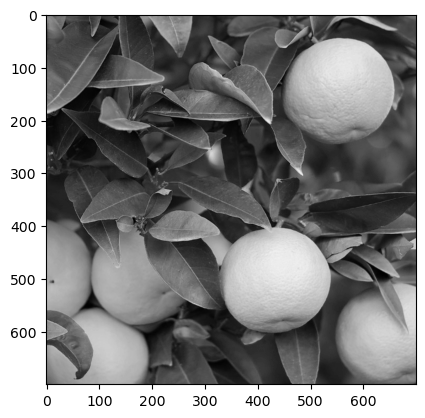

In [94]:
plt.imshow(I_circles,cmap = 'gray');

In [106]:
E = cv2.Canny(I_circles,125,130)

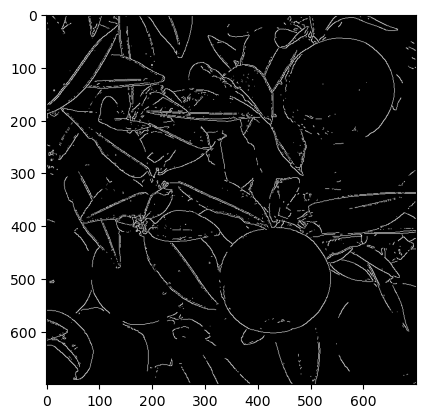

In [107]:
plt.imshow(E, cmap= 'gray')

In [6]:
def f_randomSample(r,c,n):
    totalPoints = len(r)
    idx = np.random.permutation(np.arange(totalPoints))
    idx = idx[:n]
    r2,c2 = [],[]
    for i in range(len(idx)):
        r2.append(r[idx[i]])
        c2.append(c[idx[i]])
    return r2,c2

In [9]:
r = np.arange(10)
c = np.arange(10)[::-1]
r2,c2 = f_randomSample(r,c,2)
print(r2, c2)

[6, 1] [3, 8]


# Quiz

In [10]:
r = np.arange(20)
c = np.arange(20)[::-1]
r2,c2 = f_randomSample(r,c,9)
print(r2, c2)

[16, 0, 14, 13, 6, 17, 9, 15, 10] [3, 19, 5, 6, 13, 2, 10, 4, 9]


# Line Equation

In [29]:
def f_fitLine(r1,c1,r2,c2):
    p = np.array([1,1])
    A = np.array([[r1,1],[r2,1]])
    q = np.array([[c1],[c2]])
    
    if np.linalg.det(A) != 0:
        p = np.linalg.inv(A).dot(q)
    a,b, = p[0],p[1]
    return a, b

In [32]:
r = np.arange(10)
c = np.arange(10)[::-1]
r2,c2 = f_randomSample(r,c,2)
a,b = f_fitLine(r2[0],c2[0],r2[1],c2[1])
print(a,b)

[-1.] [9.]


# Computing Consistency Score of Given Line

In [34]:
def f_getConsistencyScore(r,c,th,a,b):
    score = 0
    for i in range(len(r)):
        squaredError = (a*r[i]+b-c[i])**2
        if squaredError < th:
            score += 1
    return score

In [58]:
def f_RANSACLine(E):
    E = E>0
    # Getting all non-zero values
    idx = np.argwhere(E)
    r,c = idx[:,0],idx[:,1]
    best_a, best_b = 0 , 0
    maxScore = -1
    numIter = 100
    for iter in range(numIter):
        r2,c2 = f_randomSample(r,c,2)
        a,b = f_fitLine(r2[0],c2[0],r2[1],c2[1])
        score = f_getConsistencyScore(r,c,2,1,b)
        if score > maxScore:
            maxScore = score
            best_a,best_b = a,b
    return best_a, best_b

In [108]:
# E.max(),E.min()
best_a, best_b = f_RANSACLine(E)

In [109]:
best_a,best_b

(array([0.23899371]), array([92.16352201]))

# Drawing Your Line

In [76]:
def f_getExtents(a,b,numRows,numCols):
    # print('Starting')
    r1 = int(0)
    c1 = int(a*r1 + b)
    r2 = int(numRows - 1)
    c2 = int(a*r2+b)
    # print('Ending')
    return (c1,r1),(c2,r2)

In [110]:
# print(E.shape[0])
# print(E.shape[1])
s,e = f_getExtents(best_a,best_b,E.shape[0],E.shape[1])
print(s,e)

(92, 0) (259, 699)


C:\Users\Sophi\AppData\Local\Temp\ipykernel_96456\474047844.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  c1 = int(a*r1 + b)
C:\Users\Sophi\AppData\Local\Temp\ipykernel_96456\474047844.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  c2 = int(a*r2+b)


In [111]:
E2 = np.zeros((E.shape[0],E.shape[1],3),dtype=np.uint8)
E2.shape

(700, 700, 3)

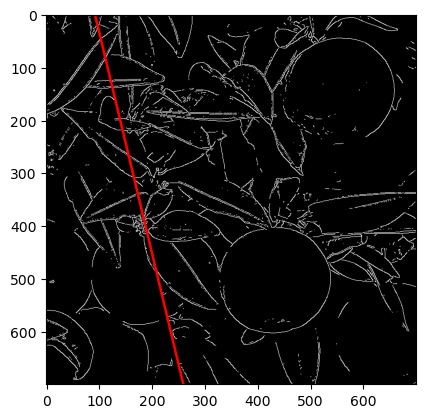

In [112]:
E3 = np.array(E,np.uint8)
# Converting back from (0,1) to (0,255)
# E3[E3==0] = 255
E2[:,:,0] = E3
E2[:,:,1] = E3
E2[:,:,2] = E3
# plt.imshow(E2)
I = cv2.line(E2,s,e,(0,0,255),3)
plt.imshow(I[:,:,::-1])

# Circle Detection using RANSAC

In [86]:
def f_fitCircle(x1,y1,x2,y2,x3,y3):
    c = (x1-x2)**2 + (y1-y2)**2
    a = (x2-x3)**2 + (y2-y3)**2
    b = (x3-x1)**2 + (y3-y1)**2
    s = 2*(a*b + b*c + c*a) - (a*a+b*b+c*c)
    px = (a*(b+c-a)*x1 + b*(c+a-b)*x2 + c*(a+b-c)*x3) / s
    py = (a*(b+c-a)*y1 + b*(c+a-b)*y2 + c*(a+b-c)*y3) / s
    ar = a**.5
    br = b**.5
    cr = c**.5
    r = ar*br*cr / ((ar+br+cr)*(-ar+br+cr)*(ar-br+cr)*(ar+br-cr))**.5
    return px,py,r

In [87]:
def f_getConsistencyScore_Circle(r,c,th,cr,cc,d):
    score = 0
    for i in range(len(r)):
        sd = ((r[i]-cr)**2 + (c[i]-cc)**2 - d**2)**2
        if sd < th:
            score += 1
    return score

In [89]:
def f_RANSACCircle(E):
    E = E>0
    # Getting all non-zero values
    idx = np.argwhere(E)
    r,c = idx[:,0],idx[:,1]
    best_cr, best_cc, best_d = 0, 0, 0
    maxScore = -1
    numIter = 1000
    for iter in range(numIter):
        r2,c2 = f_randomSample(r,c,3)
        cr,cc,d = f_fitCircle(r2[0],c2[0],r2[1],c2[1],r2[2],c2[2])
        score = f_getConsistencyScore_Circle(r,c,2,cr,cc,d)
        if score > maxScore:
            maxScore = score
            best_cr, best_cc, best_d = cr,cc,d
    return best_cr, best_cc, best_d

In [116]:
best_cr, best_cc, best_d = f_RANSACCircle(E)

In [117]:
best_cr, best_cc, best_d

(282.2265514431531, 294.99461766093407, 165.0204039874776)

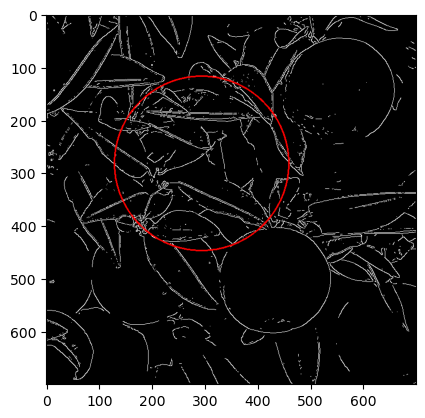

In [118]:
E3 = np.array(E,np.uint8)
# Converting back from (0,1) to (0,255)
# E3[E3==0] = 255
E2[:,:,0] = E3
E2[:,:,1] = E3
E2[:,:,2] = E3
# plt.imshow(E2)
I = cv2.circle(E2,(int(best_cc),int(best_cr)),int(best_d),(0,0,255),2)
plt.imshow(I[:,:,::-1])